In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [65]:
np.random.seed(42)

# Membuat list dari data yang akan dimasukkan ke dalam DataFrame
user_ids = np.random.randint(1, 101, size=1000)
item_ids = np.random.randint(1, 21, size=1000)
ratings = np.random.randint(1, 5, size=1000)

# Membuat DataFrame dari list yang sudah dibuat
df = pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})

In [66]:
# menghitung jumlah baris sebelum penghapusan duplikat
rows_before = df.shape[0]

# mengurutkan dataframe berdasarkan user_id ascending dan item_id ascending
df = df.sort_values(by=['user_id', 'item_id', 'rating'], ascending=[True, True, True])
df = df.drop_duplicates(subset=['user_id', 'item_id'], keep='last')

# menghitung jumlah baris setelah penghapusan duplikat
rows_after = df.shape[0]

# menghitung selisih jumlah baris
rows_deleted = rows_before - rows_after

# mengeprint jumlah baris yang dihapus
print(f"Jumlah baris yang dihapus: {rows_deleted}")

Jumlah baris yang dihapus: 216


In [67]:
df.head(10)

,user_id,item_id,rating
274,1,4,2
535,1,5,4
146,1,6,3
230,1,7,4
112,1,8,4
705,1,11,2
930,1,12,4
738,1,15,1
827,1,16,2
491,1,18,4


In [74]:
# Melakukan pivot tabel dengan index=user_id, columns=item_id, values=ratings
df_pivot = df.pivot(index='user_id', columns='item_id', values='rating')

# Mengganti nama kolom menjadi item_id1, item_id2, item_id3, hingga item_id20
df_pivot.columns = ['item_id_'+str(col) for col in df_pivot.columns]

# Menghapus index kolom agar tidak terdapat nama kolom pada indexnya
df_pivot.columns.name = None

# Menggabungkan kembali data rating dengan index user_id
df_pivot = df_pivot.reset_index().rename_axis(None, axis=1)
df_pivot.head(10)

,user_id,item_id_1,item_id_2,item_id_3,item_id_4,item_id_5,item_id_6,item_id_7,item_id_8,item_id_9,...,item_id_11,item_id_12,item_id_13,item_id_14,item_id_15,item_id_16,item_id_17,item_id_18,item_id_19,item_id_20
0,1,NaN,NaN,NaN,2.0,4.0,3.0,4.0,4.0,NaN,...,2.0,4.0,NaN,NaN,1.0,2.0,NaN,4.0,NaN,3.0
1,2,1.0,3.0,2.0,2.0,3.0,NaN,NaN,NaN,3.0,...,3.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,4.0
2,3,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,...,3.0,3.0,2.0,3.0,4.0,NaN,3.0,3.0,NaN,3.0
3,4,NaN,4.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,...,1.0,4.0,NaN,NaN,2.0,NaN,NaN,4.0,NaN,4.0
4,5,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,4.0,NaN,2.0,NaN,3.0,4.0,3.0,NaN
5,6,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,...,1.0,NaN,NaN,3.0,4.0,3.0,2.0,NaN,NaN,NaN
6,7,NaN,4.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,2.0,NaN
7,8,2.0,NaN,2.0,NaN,3.0,3.0,NaN,1.0,4.0,...,NaN,NaN,NaN,2.0,NaN,1.0,3.0,3.0,NaN,2.0
8,9,4.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
9,10,2.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [69]:
# Split dataset
train_data, val_data = train_test_split(df, test_size=.20)

# Get unique user and item IDs
unique_user_ids = np.unique(df['user_id'])
unique_item_ids = np.unique(df['item_id'])

# Create mapping from IDs to indices
user_id_to_idx = {old: new for new, old in enumerate(unique_user_ids)}
item_id_to_idx = {old: new for new, old in enumerate(unique_item_ids)}

# Replace IDs with indices in the data
train_data['user_id'] = train_data['user_id'].map(user_id_to_idx)
train_data['item_id'] = train_data['item_id'].map(item_id_to_idx)
val_data['user_id'] = val_data['user_id'].map(user_id_to_idx)
val_data['item_id'] = val_data['item_id'].map(item_id_to_idx)

In [70]:
# Set up the TensorFlow model
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_size, embeddings_regularizer=tf.keras.regularizers.L2(1e-6))
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_size, embeddings_regularizer=tf.keras.regularizers.L2(1e-6))
        self.dense_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
        ])
        self.prediction_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        user_embedded = self.user_embedding(inputs[:, 0])
        item_embedded = self.item_embedding(inputs[:, 1])
        concatenated = tf.keras.layers.concatenate([user_embedded, item_embedded])
        dense_out = self.dense_layers(concatenated)
        return self.prediction_layer(dense_out)

In [71]:
# Initialize model
model = RecommenderNet(num_users=len(user_id_to_idx), num_items=len(item_id_to_idx), embedding_size=64)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Create TensorFlow dataset
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[['user_id', 'item_id']].values, train_data['rating'].values)).shuffle(len(train_data)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data[['user_id', 'item_id']].values, val_data['rating'].values)).batch(batch_size)

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 7.7969 - root_mean_squared_error: 2.7923 - val_loss: 8.1220 - val_root_mean_squared_error: 2.8499
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 7.1642 - root_mean_squared_error: 2.6766 - val_loss: 7.3550 - val_root_mean_squared_error: 2.7120
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 6.3176 - root_mean_squared_error: 2.5135 - val_loss: 6.3001 - val_root_mean_squared_error: 2.5100
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 5.1819 - root_mean_squared_error: 2.2764 - val_loss: 4.9312 - val_root_mean_squared_error: 2.2206
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 3.8332 - root_mean_squared_error: 1.9579 - val_loss: 3.3845 - val_root_mean_squared_error: 1.8397
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 2.4362 - root_mean_squared_error: 1.5608 - val_loss: 2.0820 - val_root_

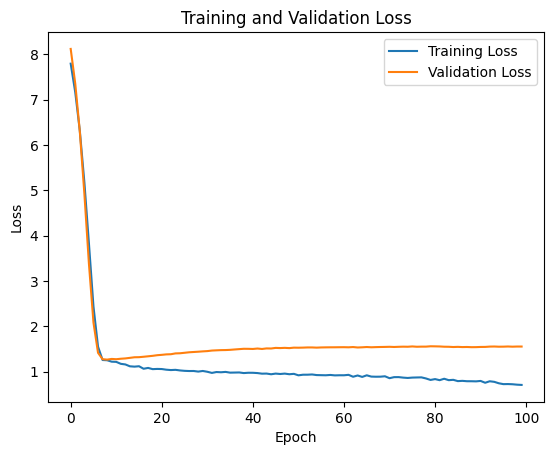

In [72]:
# Plot history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
# Create a DataFrame of all user-item pairs that have not been rated
user_item_pairs = []
for user_id in unique_user_ids:
    user_items_rated = df[df['user_id'] == user_id]['item_id'].values
    user_items_unrated = np.setdiff1d(unique_item_ids, user_items_rated)
    for item_id in user_items_unrated:
        user_item_pairs.append([user_id, item_id])
user_item_df = pd.DataFrame(user_item_pairs, columns=['user_id', 'item_id'])

# Map IDs to indices in the user-item DataFrame
user_item_df['user_id'] = user_item_df['user_id'].map(user_id_to_idx)
user_item_df['item_id'] = user_item_df['item_id'].map(item_id_to_idx)

# Make predictions for all user-item pairs
user_item_array = user_item_df[['user_id', 'item_id']].values
ratings_pred = model.predict(user_item_array).flatten()

# Add predicted ratings to the user-item DataFrame
user_item_df['rating_pred'] = ratings_pred

# Get the top-rated items for each user
top_items = user_item_df.groupby('user_id').apply(lambda x: x.nlargest(5, 'rating_pred')).reset_index(drop=True)

# Map indices back to IDs
top_items['user_id'] = top_items['user_id'].map({v: k for k, v in user_id_to_idx.items()})
top_items['item_id'] = top_items['item_id'].map({v: k for k, v in item_id_to_idx.items()})

# Print the results
for user_id, items in top_items.groupby('user_id'):
    print(f"User {user_id} recommends:")
    for index, row in items.iterrows():
        item_id = row['item_id']
        rating_pred = row['rating_pred']
        print(f"- item {item_id} with predicted rating {rating_pred:.2f}")
    print()


38/38 [==============================] - 0s 2ms/step
User 1 recommends:
- item 10.0 with predicted rating 3.05
- item 17.0 with predicted rating 2.95
- item 1.0 with predicted rating 2.94
- item 2.0 with predicted rating 2.89
- item 9.0 with predicted rating 2.84

User 2 recommends:
- item 16.0 with predicted rating 2.79
- item 18.0 with predicted rating 2.75
- item 8.0 with predicted rating 2.74
- item 17.0 with predicted rating 2.51
- item 10.0 with predicted rating 2.49

User 3 recommends:
- item 5.0 with predicted rating 3.74
- item 16.0 with predicted rating 3.64
- item 2.0 with predicted rating 3.23
- item 1.0 with predicted rating 3.22
- item 8.0 with predicted rating 3.22

User 4 recommends:
- item 16.0 with predicted rating 3.39
- item 5.0 with predicted rating 3.32
- item 4.0 with predicted rating 3.15
- item 8.0 with predicted rating 3.15
- item 1.0 with predicted rating 3.01

User 5 recommends:
- item 20.0 with predicted rating 3.73
- item 16.0 with predicted rating 3.71
- 